## Library

In [ ]:
!pip install transformers
!pip install sentence_transformers
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 108.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.6 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=a60c57186e314f3de82e4f3116d14fa03e425d06e6bb457784d639b70d653b9d
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 6.1 MB

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import AutoModelForSequenceClassification,Trainer,AutoTokenizer,TrainingArguments
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,f1_score,precision_score
from sklearn.model_selection import train_test_split

In [ ]:
%cd /content/drive/MyDrive/classification

/content/drive/MyDrive/classification


## Data preprocessing

In [ ]:
dataset = "2"

if dataset == "1":

    df = pd.read_excel("./BERT/BERT/1/Constraint_Train.xlsx")
    #df = pd.read_excel("Constraint_Train.xlsx")
    # test_df  = pd.read_excel("./BERT/BERT/1/Constraint_Test.xlsx")

elif dataset == "2":

    df = pd.read_excel("./BERT/BERT/2/texts_labeled_cleaned.xlsx")
    #df = pd.read_excel("texts_labeled_cleaned.xlsx")
    df.columns = ["tweet","label"]


    df,test_df = train_test_split(df,test_size=0.1,random_state=12)

elif dataset == "3":

    train = pd.read_csv('./BERT/BERT/3/train.csv',delimiter='\t')
    test = pd.read_csv('./BERT/BERT/3/test.csv',delimiter='\t')
    valid = pd.read_csv('./BERT/BERT/3/valid.csv',delimiter='\t')
    #train = pd.read_csv('train.csv',delimiter='\t')
    #test = pd.read_csv('test.csv',delimiter='\t')
    #valid = pd.read_csv('valid.csv',delimiter='\t')

    replace_dict = {'half-true': 0, 'mostly-true': 0, 'false': 0, 'true': 1, 'barely-true': 0, 'pants-fire': 0}

    train['false'] = train['false'].replace(replace_dict)

    test['true'] = test['true'].replace(replace_dict)

    valid['barely-true'] = valid['barely-true'].replace(replace_dict)

    value_counts = train['false'].value_counts()

    label_train = train['false'].tolist()
    label_test = test['true'].tolist()
    train_set = train['Says the Annies List political group supports third-trimester abortions on demand.'].tolist()
    test_set = test['Building a wall on the U.S.-Mexico border will take literally years.'].tolist()
    unlabeled = valid['We have less Americans working now than in the 70s.'].tolist()
    df = pd.DataFrame({"tweet" : train_set + test_set,
              "label" : label_train + label_test })

    test_df = pd.DataFrame({"tweet" : unlabeled} )




class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

encoder     = LabelEncoder()
df['label'] = encoder.fit_transform( df['label'] )

In [ ]:
df

,tweet,label
415,Lewis Hamilton says he will sit out world titl...,0
943,Are Autonomous Cars Ready to Go It Alone?\n\nT...,1
722,Tom Cruise awkwardly swerves question about da...,1
538,Billy Bush officially sacked from NBC Today sh...,1
557,Ellen DeGeneres sends her producer to another ...,1
...,...,...
241,Ellen DeGeneres Dines With Mystery Brunette Am...,0
253,Mexicans Are Chomping at the Bit to Stop NAFTA...,0
390,"Judge tells Stein, 'Your money's no good here!...",0
667,Kim Kardashian Opens Up to About Life After th...,1


## Loading model from the Transformers library

In [ ]:
model_name =  "Mikael110/llama-2-7b-guanaco-fp16"
#model_name =  "TheBloke/guanaco-7B-GGML"
from transformers import LlamaForSequenceClassification, LlamaTokenizer

tokenizer = LlamaTokenizer.from_pretrained(model_name)

id2label = {0 : 0  }
label2id = {0 : 0}

model = LlamaForSequenceClassification.from_pretrained(model_name,num_labels=1, id2label=id2label, label2id=label2id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at Mikael110/llama-2-7b-guanaco-fp16 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_df,val_df = train_test_split(df,test_size=0.2,random_state=12)

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    # model.resize_token_embeddings(len(tokenizer))

train_encoding =  tokenizer(train_df['tweet'].values.tolist(), truncation=True, padding=True, max_length=128)

val_encoding   = tokenizer(val_df['tweet'].values.tolist(), truncation=True, padding=True, max_length=128)
train_dataset = TextDataset(train_encoding,train_df['label'].values.tolist())
val_dataset   = TextDataset(val_encoding,val_df['label'].values.tolist())


## Extract Embedding

In [ ]:
from tqdm.auto import tqdm

In [ ]:
import torch

# Check for available GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"There are {torch.cuda.device_count()} GPU(s) available.")
    print("Device name:", torch.cuda.get_device_name(0))

else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")


There are 1 GPU(s) available.
Device name: NVIDIA A100-SXM4-40GB


In [ ]:
model.to(device)

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (nor

In [ ]:
def embedding_data(sets):
    loader = DataLoader(sets, shuffle=False, batch_size=1)
    data, label = [], []
    for batch in tqdm(loader):
        try:
            batch = {k: v.to(device) for k, v in batch.items()}

            out = model(**batch)

            embedding = out.past_key_values[0][0][0].mean(axis=-1).reshape(-1).detach().cpu().numpy()

            data.append(embedding)
            label.append(batch["labels"].cpu().item())

        except Exception as e:
            print(f"An error occurred: {e}")
            continue

    return np.array(data), np.array(label)


In [ ]:
train_embedding,train_label = embedding_data(train_dataset)

  0%|          | 0/702 [00:00<?, ?it/s]

In [ ]:
val_embedding,val_label = embedding_data(val_dataset)

  0%|          | 0/176 [00:00<?, ?it/s]

In [ ]:
train_embedding.shape

(702, 4096)

In [ ]:
val_embedding.shape

(176, 4096)

In [ ]:
train_label.shape

(702,)

In [ ]:
val_label.shape

(176,)

## Traditional classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score

In [ ]:
def compute_metrics(model_name,predict,true):
    return {
        "model_name" : model_name,
        "accuracy" : accuracy_score(true,predict),
        "f1" : f1_score(true,predict),
        "precision" : precision_score(true,predict)
    }

In [ ]:
models = [KNeighborsClassifier,LogisticRegression,DecisionTreeClassifier,MLPClassifier]
result = []
for m in models:
    model = m()
    model.fit(train_embedding,
              train_label)

    val_predict = model.predict(val_embedding)

    result.append(compute_metrics(m.__name__,
                                  val_predict,
                                  val_label))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
print("dataset:",dataset)

pd.DataFrame(result)

dataset: 2


,model_name,accuracy,f1,precision
0,KNeighborsClassifier,0.556818,0.493506,0.550725
1,LogisticRegression,0.539773,0.542373,0.521739
2,DecisionTreeClassifier,0.551136,0.558659,0.531915
3,MLPClassifier,0.528409,0.531073,0.510870


## KNN method

In [ ]:
from tqdm.auto import tqdm

Ks = [1,2,3,4,5,6,7,8,9,10,20,30]

result = []

for k in tqdm(Ks):
    model = KNeighborsClassifier(n_neighbors=k)

    model.fit(train_embedding,train_label)

    val_predict = model.predict(val_embedding)

    result.append(compute_metrics("{}".format(k),
                                  val_predict,
                                  val_label))


  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
knndf = pd.DataFrame(result)

knndf.columns = ["K","accuracy","f1","precision"]
knndf.index = knndf.K

knndf = knndf.drop(columns = ["K"])
knndf

,accuracy,f1,precision
K,,,
1,0.545455,0.487179,0.535211
2,0.511364,0.258621,0.483871
3,0.534091,0.481013,0.520548
4,0.528409,0.325203,0.526316
5,0.556818,0.493506,0.550725
6,0.500000,0.312500,0.465116
7,0.528409,0.450331,0.515152
8,0.517045,0.360902,0.500000
9,0.539773,0.456376,0.531250


<Axes: xlabel='K'>

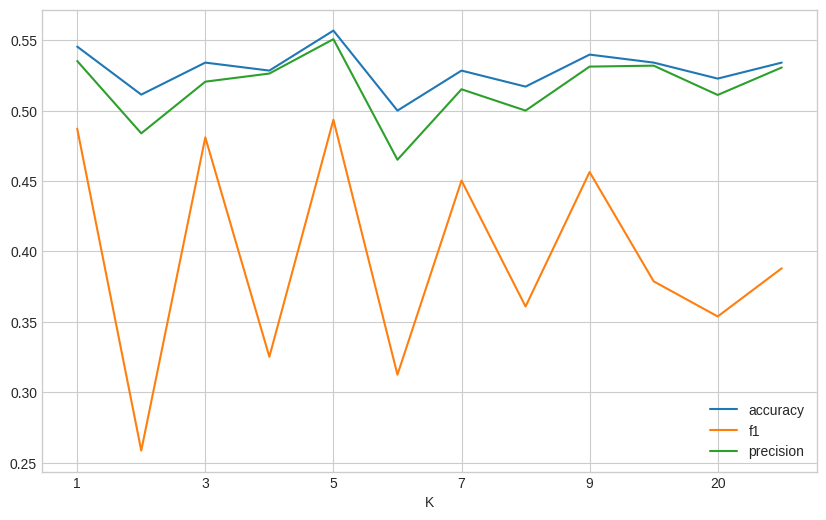

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

fig,ax = plt.subplots(1,1,figsize=(10,6))
knndf.plot(ax = ax)

In [ ]:
train_label = train_df["label"].tolist()
val_label   = val_df["label"].tolist()

In [ ]:
print(train_embedding.shape)
print(val_embedding.shape)

(702, 4096)
(176, 4096)


## CNN realization

In [ ]:
X_train = torch.tensor(train_embedding, dtype=torch.float32)
y_train = torch.tensor(train_label, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(val_embedding, dtype=torch.float32)
y_val = torch.tensor(val_label, dtype=torch.float32).unsqueeze(1)

In [ ]:
class FakeNewsClassifierCNN(nn.Module):
    def __init__(self):
        super(FakeNewsClassifierCNN, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduce dimension by half

        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduce dimension by half

        # Fully connected layers - adjust the input features accordingly
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 1)

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Adjust the reshaping of the input to suit your embedding
        x = x.view(-1, 1, 64, 64)  # Reshaping from 4096 to (1, 64, 64)

        # First conv block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)

        # Second conv block
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Define data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import random

# Setting random seeds for repeatable results
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialise model and move to GPU
model = FakeNewsClassifierCNN().to(device)

# Defining loss and optimiser
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

num_epochs = 200
best_accuracy = 0  # 保存最高准确率

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        batch_y = batch_y.view(-1, 1).float()

        optimizer.zero_grad()

        outputs = model(batch_x)
        # Applying the sigmoid activation function
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, batch_y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            batch_y = batch_y.view(-1, 1).float()

            outputs = model(batch_x)
            outputs = torch.sigmoid(outputs)  # Applying the sigmoid activation function
            predicted = (outputs > 0.5).float()
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    current_accuracy = correct/total*100
    print(f"Accuracy on validation data: {current_accuracy:.2f}%")
    # Save the highest accuracy rate
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy

print(f"Highest Accuracy on validation data: {best_accuracy:.2f}%")


Epoch 1/200, Loss: 0.775149792432785
Accuracy on validation data: 51.70%
Epoch 2/200, Loss: 0.6885386569933458
Accuracy on validation data: 51.70%
Epoch 3/200, Loss: 0.6699702956459739
Accuracy on validation data: 51.70%
Epoch 4/200, Loss: 0.65498148040338
Accuracy on validation data: 51.70%
Epoch 5/200, Loss: 0.6744429116899316
Accuracy on validation data: 51.70%
Epoch 6/200, Loss: 0.6472693437879736
Accuracy on validation data: 51.70%
Epoch 7/200, Loss: 0.6413587358864871
Accuracy on validation data: 53.41%
Epoch 8/200, Loss: 0.6323890875686299
Accuracy on validation data: 52.27%
Epoch 9/200, Loss: 0.6230827244845304
Accuracy on validation data: 53.98%
Epoch 10/200, Loss: 0.5939461290836334
Accuracy on validation data: 51.70%
Epoch 11/200, Loss: 0.6008410833098672
Accuracy on validation data: 51.70%
Epoch 12/200, Loss: 0.5791355493393812
Accuracy on validation data: 55.68%
Epoch 13/200, Loss: 0.5655360560525547
Accuracy on validation data: 59.09%
Epoch 14/200, Loss: 0.587065694007006